# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.  

**Цель работы:**  
Создать модель классификации комментариев на позитивные и негативные.  
Метрика качества - *F1*. Она должна быть не ниже 0.75.  

**Ход работы**
1. Импорт данных
2. Перевод текста в признак
    - Очистка текста
    - Лемматизация текста
    - Расчет TF-IDF
3. Обучение моделей 
4. Тестирование финальной модели

## Импорт библиотек

---
Чтобы лемматизация была быстрее, использовал pandarallel   
Но можно и без этой библиотеки, тогда будет через tqdm

In [ ]:
!pip install pandarallel
from pandarallel import pandarallel

---

In [54]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV)
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

## Импорт данных

In [55]:
try:
    data_raw = pd.read_csv('toxic_comments.csv')
except:
    data_raw = pd.read_csv('/datasets/toxic_comments.csv')
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [56]:
data_raw.sample(5)

,Unnamed: 0,text,toxic
86680,86761,Original research by 82.124.250.35\nI've added...,0
21700,21720,"""\n\n This was a """"tool"""" \n\nI'm so tired of ...",0
119617,119722,...atleast half of the items on the April Fool...,0
103690,103787,"I still think the collage is silly, especially...",0
143733,143888,The sentences didn't need to be linked. Semi-c...,0


Уберем лишний столбец *Unnamed: 0*

In [57]:
data_raw = data_raw.drop(['Unnamed: 0'], axis=1)

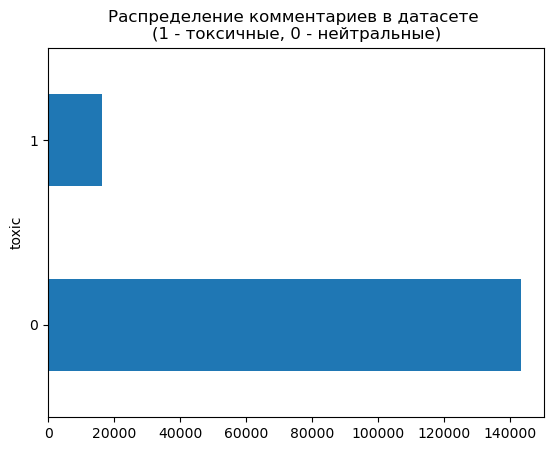

In [58]:
data_raw['toxic'].value_counts().plot(kind='barh')
plt.title('Распределение комментариев в датасете \
\n(1 - токсичные, 0 - нейтральные)')
plt.show()

## Готовим признаки

### Лемматизация текста

Скачаем из библиотеки spacy готовый пайплайн из:
 - Токенизатора
 - POS тэггера
 - Лемматизатора

In [59]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Создадим функцию, которая:
 1) Приводит текст к нижнему регистру, убирает из текса небуквенные символы, единичные буквы
 2) Токенизирует текст
 3) Убирает токены стоп-слов и токены пунктуации
 4) Возвращает леммы слов
 5) Собирает текст в одну строку

In [60]:
def clean_and_lem(text):
    lower = text.lower()
    clear = re.sub('[^a-z]', ' ', lower)
    cleared = re.sub(r'\b\w{1,2}\b', ' ', clear).split()
    sentence = ' '.join(cleared)
    doc = nlp(sentence)
    tokens = [tokens for tokens in doc if (tokens.is_stop == False)]
    tokens = [tokens for tokens in tokens if (tokens.is_punct == False)]
    final_token = [token.lemma_ for token in tokens]
    res = ' '.join(final_token)
    return res

Проверим работу функции на нескольких текстах

In [61]:
data = data_raw[0:3].copy()
data['text'] = data['text'].apply(clean_and_lem)

print('Было\n⬇️⬇️⬇️⬇️⬇️⬇️\nСтало')
for i in range(3):
    print('➖'*50)
    print(data_raw['text'][i])
    print('⬇️⬇️⬇️⬇️⬇️⬇️', end='\n\n')
    print(data['text'][i])

Было
⬇️⬇️⬇️⬇️⬇️⬇️
Стало
➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
⬇️⬇️⬇️⬇️⬇️⬇️

explanation edit username hardcore metallica fan revert weren vandalism closure gas vote new york dolls fac don remove template talk page retire
➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
⬇️⬇️⬇️⬇️⬇️⬇️

aww match background colour seemingly stuck thank talk january utc
➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the form

In [62]:
#тут нужно подождать
data = data_raw.copy()
try:
    # у меня на 6 ядрах(ноут) ~ 1 минута
    pandarallel.initialize(progress_bar=True)
    data['text'] = data['text'].parallel_apply(clean_and_lem)
except:
    # а тут ~ 10 минут 
    tqdm.pandas()
    data['text'] = data['text'].progress_apply(clean_and_lem)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Делим на выборки

Разделим на train/test выборки

In [63]:
train, test = train_test_split(
    data, test_size=0.2, stratify=data['toxic'], random_state=123)
print(train.shape, test.shape)

(127433, 2) (31859, 2)


И разделим признаки и таргет

In [64]:
X_train = train['text']
X_test = test['text']

y_train = train['toxic']
y_test = test['toxic']

## Обучение

После TfidfVectorizer мы получили признаки в виде разреженной матрицы(sparse matrix).  
Поэтому, возьмем модели, которые умеют с такой матрицей работать.  
Точность моделей будем проверять кросс-валидацией(3 фолда)

In [65]:
vectorizer = TfidfVectorizer()

### LogisticRegression

In [66]:
model = LogisticRegression(C=13, max_iter=1000, random_state=123)
pipe = make_pipeline(vectorizer, model)
cv = cross_val_score(pipe, X_train, y_train, cv=3, scoring='f1', n_jobs=4)
print('Результат f1: {:.3f}'.format(cv.mean()))

Результат f1: 0.773


Тут крутился перебор гиперпараметров. Можно раскомментировать и проверить 🙃

In [67]:
# %%time
# model = LogisticRegression(max_iter=1000, random_state=123)
# pipe = make_pipeline(vectorizer, model)
# parameters = {'logisticregression__C':np.logspace(-2, 2, 10)}
# gs = GridSearchCV(pipe, parameters, scoring='f1', cv=3, n_jobs=5)
# gs.fit(X_train, y_train)
# print(gs.best_score_)
# gs.best_params_

### LinearSVC

In [68]:
model = LinearSVC(random_state=123, dual='auto')
pipe = make_pipeline(vectorizer, model)
cv = cross_val_score(pipe, X_train, y_train, cv=3, scoring='f1', n_jobs=4)
print('Результат f1: {:.3f}'.format(cv.mean()))

Результат f1: 0.777


Тут крутился перебор гиперпараметров. Можно раскомментировать и проверить 🙃

In [69]:
# %%time
# parameters = {'linearsvc__C':np.logspace(-1, 1, 10)}
# gs = GridSearchCV(pipe, parameters, scoring='f1', cv=3, n_jobs=5)
# gs.fit(X_train, y_train)
# print(gs.best_score_)
# gs.best_params_

### ComplementNB

In [70]:
model = ComplementNB(alpha=0.2)
pipe = make_pipeline(vectorizer, model)
cv = cross_val_score(pipe, X_train, y_train, cv=3, scoring='f1', n_jobs=4)
print('Результат f1: {:.3f}'.format(cv.mean()))

Результат f1: 0.671


Тут крутился перебор гиперпараметров. Можно раскомментировать и проверить 🙃

In [71]:
# %%time
# parameters = {'complementnb__alpha':np.logspace(-2, 1, 10)}
# gs = GridSearchCV(pipe, parameters, scoring='f1', cv=3, n_jobs=5)
# gs.fit(X_train, y_train)
# print(gs.best_score_)
# gs.best_params_

---
По итогам лучший результат на тренировочной выборке показала модель LinearSVC

## Тестирование

Узнаем результат на тестовой выборке

In [72]:
model = LinearSVC(random_state=123, dual='auto')
pipe = make_pipeline(vectorizer, model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Результат f1: {:.3f}'.format(f1_score(y_test, y_pred)))

Результат f1: 0.786


## Выводы

Для задачи классификации комментариев на негативные и позитивные были обучены и протестированы несколько моделей.  
Обучались модели на размеченных комментариях, переведенных в матрицу векторов *TF-IDF*(оценки важности слова в контексте документа).  

Наилучший результат на тестовой выборке показала модель **LinearSVC** с **F1 = 0.786** (требуемый результат >0.75)